# 10. 画像処理分野 解説

## 概要

本演習では ResNet の Residual Block を穴埋め形式で実装します。

演習問題文は<font color="Red">赤字</font>です。


### ライブラリのインポート

必要なライブラリのインストールを行います。

In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, wide_resnet50_2

try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
    
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
    torch.backends.cudnn.benchmark = True

# GPU が利用できる場合は、GPU上で学習を行います。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### データセットの準備

データセットには、cifar10 を使用します。

cifar10 は10種類のクラスを含まれており、  
学習データ 50000枚、テストデータ 10000枚で構成されています。

データは 3チャンネル(RGB)の縦横 32×32 の配列`(3, 32, 32)`となっています。

本演習では実行時間の関係上、飛行機と自動車の画像500枚ずつに限定して学習します。

In [3]:
# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# 学習データに適用する前処理
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),   # 短い辺の長さがresizeの大きさになる
    transforms.RandomHorizontalFlip(),          # ランダムに左右に反転する
    transforms.ToTensor(),                      # Torchテンソルに変換
    transforms.Normalize(mean, std)             # 色情報の標準化
])
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=train_transform
)

num_data = 500
num_classes = 2

# 学習データから飛行機と自動車の画像を抽出
mini_data = [[] for x in range(num_classes)]
idx_list = list(range(2))
for img, tgt in zip(trainset.data, trainset.targets):
    if tgt in idx_list and len(mini_data[tgt]) < num_data:
        mini_data[tgt].append(img)
mini_data = np.array(mini_data, dtype=trainset.data.dtype).reshape(-1, 32, 32, 3)

# 学習データ用の正解ラベルを作成
mini_targets = []
for i in idx_list:
    tgt = [i] * num_data
    mini_targets += tgt
  
# 学習データの置き換え
trainset.data = mini_data
trainset.targets = mini_targets

# 学習データのデータローダ
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    shuffle=True, num_workers=2
)

# テストデータに適用する前処理
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 短い辺の長さがresizeの大きさになる
    transforms.ToTensor(),              # Torchテンソルに変換
    transforms.Normalize(mean, std)     # 色情報の標準化
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=test_transform
)

# テストデータから飛行機と自動車の画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(testset.data, testset.targets):
    if tgt in idx_list:
        mini_data[tgt].append(img)
mini_data = np.array(mini_data, dtype=testset.data.dtype).reshape(-1, 32, 32, 3)

# テストデータ用の正解ラベルを作成
mini_targets = []
for i in idx_list:
    tgt = [i] * 1000
    mini_targets += tgt

# テストデータの置き換え
testset.data = mini_data
testset.targets = mini_targets

# テストデータのデータローダ
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 1. ResNetを用いたCIFAR10の分類

### ResNetについて

CNNでは多層化することでネットワークの表現能力が向上することが知られているが、同時に入力層付近で勾配消失が起こりうまく学習できなくなってしまうという問題や勾配消失以外にも単純に層を深くすると反って精度が悪くなってしまうという劣化問題もあります。

ResNetのResidual Blockは勾配消失や劣化問題に対して、skip connectionを導入することで勾配が出力層から入力層まで消失することなく伝播できるようになり、ネットワークをより多層化することができました。

### bottleneckのアーキテクチャ

3層の畳み込み層とskip connectionから構成されます。
図の例では、256次元の特徴マップが入力された場合の構造を示しています。

この構造のポイントは、
- 1層目と二層目の畳み込み層で次元数を減少させることで、必要なパラメータ数を削減している。
- 3層目の次元数を復元することで、最終的に得られる特徴マップのサイズはPlainアーキテクチャと同じになる。

このような構造により、同じパラメータ数で多層化することができるという利点があります。

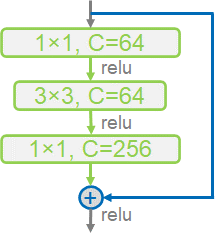

また、重要な特徴表現を獲得するためには、次元数を増加させる必要があります。そのため、ResNetでは各レイヤーで１回ダウンサンプリングすることで次元数を増やす処理を行っています。

### ResNet の実装

TorchVision ライブラリでは、VGG や ResNet など有名なネットワークはすでに実装されていて、手軽に利用できます。  
本演習では理解のために ResNet の Residual Block のみを自ら実装してみましょう。  
また、今回扱う Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問1. ResNet の Bottleneck を完成させてください。</font>
  * <font color="Red">問1-1. ダウンサンプリングを行う処理を記述してください。</font>
  * <font color="Red">問1-2. skip connectionを行う処理を記述してください。</font>

【ヒント】
skip connectionは畳み込み層の出力`x`と層をまたいだ`shortcut`を足し合わせる処理です。

In [4]:
class Bottleneck(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(
            input_dim, output_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(
            output_dim, output_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.conv3 = nn.Conv2d(
            output_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            shortcut = self.downsample(shortcut) ### 問1-1 ###

        x += shortcut ### 問1-2 ###
        x = self.relu(x)

        return x

#### <font color="Red">問1 解説</font>

まず、畳み込みニューラルネットワークにおけるダウンサンプリングとは、画像の特徴量マップの面積を小さくすることです。これは、プーリング層や、ストライドが2以上の畳み込み層により実現できます。

forwardメソッドは、 順伝播を記述する部分です。最初の入力が`x`で、`shortcut`には`x`の複製を保存しておきます。その後は、畳み込み(conv)、バッチ正規化(bn)、ReLU(relu)を何回かはさみ、skip connectionを行い、最後にReLUに代入します。
この時に、`downsample`引数がTrue(=self.downsampleがNone)の場合は`shortcut`をダウンサンプリングしておくのが問1-1です。Bottleneckクラスのdownsampleメソッドに`shortcut`を代入すれば答えです。

skip connectionは、図中の青線部分に相当します。最初の入力を`shortcut`として複製
しておいたので、これを3つ目の畳み込み層の出力に足してあげればBottleneckの完成です。

上記で実装した Bottleneck を用いて、ResNet50 を実装します。

<font color="Red">問2-1~2-4. 各`layer`の最初の`Bottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。</font>

In [5]:
# torchvision より実装済みの ResNet50 を呼び出し
model_resnet50 = resnet50(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_resnet50.layer1 = nn.Sequential(
    Bottleneck(64, 64, downsample=True), ### 問2-1 ###
    Bottleneck(256, 64),
    Bottleneck(256, 64)
)
model_resnet50.layer2 = nn.Sequential(
    Bottleneck(256, 128, downsample=True), ### 問2-2 ###
    Bottleneck(512, 128),
    Bottleneck(512, 128),
    Bottleneck(512, 128)
)
model_resnet50.layer3 = nn.Sequential(
    Bottleneck(512, 256, downsample=True), ### 問2-3 ###
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256)
)
model_resnet50.layer4 = nn.Sequential(
    Bottleneck(1024, 512, downsample=True), ### 問2-4 ###
    Bottleneck(2048, 512),
    Bottleneck(2048, 512)
)

# ResNet50 のアーキテクチャの表示
model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### <font color="Red">問2 解説</font>

torchvisionから読み込んだmodel_resnet50は、4つのlayerから構成されており、各layerはnn.Sequentialクラスで定義されます。nn.Sequentialクラスは、複数のモデルを配列のように並べることで一つのモデルとして表現します。さらに各nn.Sequentialクラスの中に、複数のBottleneckクラスが定義されています。この各Bottleneckクラスの一部をいじるのが問2です。

問1で、Bottleneckクラスの`__init__`でdownsampleという引数を読み込んでいたことを思い出しましょう。つまり、各layerの最初のBottleneckでのみdownsample=Trueと
指定すれば良いです。

### Fine-tuning

ResNet では、Fine-tunig を行います。

Fine-tunig とは、事前学習で得られたパラメータを再利用する学習方法です。

まずは、torchvision で配布されている事前学習パラメータを読み込みます。

In [6]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/resnet50-0676ba61.pth", progress=True)
model_resnet50.load_state_dict(state_dict=state_dict)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

torchvision に実装されている ResNet50 の出力層は 1000クラスを分類するようになっています。  
しかし、本演習では飛行機と自動車の 2クラス分類のため出力層を追加する必要があります。

### <font color="Red">問3. 2クラス分類を行うために出力層を変更してください。出力サイズは`2`とします。</font>

【ヒント】

`feat_dim = model_resnet50.fc.in_features` では出力層の入力の次元数を取得しています。

In [7]:
feat_dim = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(feat_dim, 2) #### 問3 ####

#### <font color="Red">問3 解説</font>

model_resnet50と打ってネットワーク構造を観察すればわかるように、このネットワークの最終層である全結合層の名前はfcです。fcの出力次元数out_featuresには1000が設定されており、これは入力された画像を1000クラス分類することを想定しています。本演習では飛行機と自動車の2クラス分類を行うため、1000を2に置き換える必要があります。よって、model_resnet50.fcにnn.Linear(入力次元数, 2)を代入します。

問3で追加した出力層のパラメータのみを学習によって最適化します。

<font color="Red">問4. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

【ヒント】

`model_resnet50`の出力層のパラメータのみを`torch.nn.SGD`の引数に与えます。

In [8]:
# oprimizer
optimizer = torch.optim.SGD(model_resnet50.fc.parameters(), lr=0.001, momentum=0.9) ### 問4 ###

# 損失関数
loss_fn = nn.CrossEntropyLoss()

#### <font color="Red">問4 解説</font>

"pytorch sgd"などで検索すると、公式ドキュメントhttps://pytorch.org/docs/stable/generated/torch.optim.SGD.html　が見つかると思います。ここを読むと、`param`引数に最適化したいパラメータを渡すことがわかります。よって、torch.optim.SGDクラスに`model_resnet50`の出力層のパラメータ、学習率`lr`、モーメンタム`momentum`を渡せばいいです。`model_resnet50`の出力層のパラメータは、.fc.parameters()メソッドで呼び出せます。

### 学習

５エポックで精度が80%以上になっていれば学習成功です。

学習には、GPU環境で15~20分ほどかかります。

GPU環境でない場合、学習にかなりの時間が必要になると思われます。  
Google ColabのGPU環境で実行することを推奨します。

In [9]:
model_resnet50.to(device)

for epoch in range(5):
    print("Epoch: {}".format(epoch + 1))

    model_resnet50.train()
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch + 1 in [2, 5]:
        model_resnet50.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model_resnet50(inputs)
                _, preds = torch.max(outputs, 1)

                total += inputs.size(0)
                correct += torch.sum(preds == labels.data)
        print("認識精度: {}".format(100 * (correct / total)))

Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 62.600006103515625
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 85.80000305175781



## 2. WideResNetを用いたCIFAR10の分類

### WideResNetについて

WideResNetは、ResNetの層数を減らし各層の次元数を増加させることで精度を向上させるネットワークになっています。

このような変更を加えたメリットとして以下が挙げられます。
- 次元数を増やすことで、層数が少なくても十分な特徴表現を獲得できる。
- 畳み込み層は、次元数が増えたとしても並列計算できるためあまりの計算コストが増加しない。WideResNetではその分層数を減らしているため、より計算コストを削減することができる。

また、層を深くしたWideResNetでは畳み込み層の間にDropoutを用いることで、精度が向上することも報告されている。

### bottleneckのアーキテクチャ

WideResNetのbottleneckとResnetのbottleneckの違いは、畳み込み層の2層目の次元数をk倍している部分です。

以下の図の例では、`k=2`を採用しています。

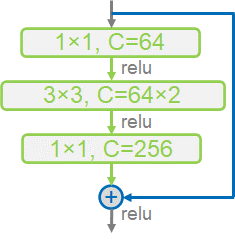

### WideResNet の実装

ResNet に引き続き、WideResNet も Residual Block のみを自ら実装してみましょう。  
ResNet 同様、Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問5. WideResNet の Bottleneck を完成させてください。</font>
  * <font color="Red">問5-1. ダウンサンプリングを行う処理を記述してください。</font>
  * <font color="Red">問5-2. skip connectionを行う処理を記述してください。</font>

【ヒント】
skip connectionは畳み込み層の出力`x`と層をまたいだ`shortcut`を足し合わせる処理です。

In [10]:
class WideBottleneck(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(WideBottleneck, self).__init__()

        hidden_dim = output_dim * 2

        self.conv1 = nn.Conv2d(
            input_dim, hidden_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(
            hidden_dim, hidden_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.conv3 = nn.Conv2d(
            hidden_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            shortcut = self.downsample(shortcut)  ### 問5-1 ###

        x += shortcut ### 問5-2 ###
        x = self.relu(x)

        return x

#### <font color="Red">問5 解説</font>

WideBottleneckとBottleneckの違いは、畳み込み層の2層目の次元数をk倍している部分でした。コードでいうと、`hidden_dim`という変数を用いている部分ですが、この部分以外はBottleneckと同様と考えて構わないでしょう。
よって、問1と同じように書き足せば答えとなります。

上記で実装した Bottleneck を用いて、WideResNet50 を実装します。

<font color="Red">問6-1~6-4. 各`layer`の最初の`WideBottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。</font>

In [11]:
# torchvision より実装済みの WideResNet50 を呼び出し
model_wide_resnet50 = wide_resnet50_2(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True), ### 問6-1 ###
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50.layer2 = nn.Sequential(
    WideBottleneck(256, 128, downsample=True), ### 問6-2 ###
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50.layer3 = nn.Sequential(
    WideBottleneck(512, 256, downsample=True), ### 問6-3 ###
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50.layer4 = nn.Sequential(
    WideBottleneck(1024, 512, downsample=True), ### 問6-4 ###
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
model_wide_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

#### <font color="Red">問6 解説</font>

問2と同じように書き換えれば完成です。ただし、今度はBottleneckがWideBottleneckに置き換わっている点に注意しましょう。

### 転移学習

WideResNet では、転移学習を行います。

転移学習とは、事前学習で得られたパラメータを固定し、新たに追加した層のみを学習する手法です。

まずは、torchvision で配布されている事前学習パラメータを読み込みます。

In [12]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth", progress=True)
model_wide_resnet50.load_state_dict(state_dict=state_dict)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

<All keys matched successfully>

次に、事前学習されたパラメータを固定します。  
固定されたパラメータは学習されません。

<font color="Red">問7. 事前学習で使用されたモデルパラメータを固定する処理を完成させてください。</font>

In [13]:
for param in model_wide_resnet50.parameters():
    param.requires_grad = False #### 問7 ####

#### <font color="Red">問7 解説</font>
ひとまず全てのモデルパラメータを固定して、その後問8で全結合層を追加する方針をとります。
for文で`model_wide_resnet50`の全パラメータについてrequires_gradをFalseにするのが簡単でしょう。requires_gradは、その名前の通り、勾配の計算をするかどうかの設定に関わります。

さらに、2クラス分類に2クラス分類のため出力層を追加しましょう。

<font color="Red">問8. 2クラス分類を行うために出力層を追加してください。</font>

In [14]:
feat_dim = model_wide_resnet50.fc.in_features
model_wide_resnet50.fc = nn.Linear(feat_dim, 2) #### 問8（問3と同じ）####

#### <font color="Red">問8 解説</font>
問3と同じです。


<font color="Red">問9. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

In [15]:
# oprimizer
optimizer = torch.optim.SGD(model_wide_resnet50.fc.parameters(), lr=0.001, momentum=0.9) ### 問9 ###

# 損失関数
loss_fn = nn.CrossEntropyLoss()

#### <font color="Red">問9 解説</font>
問4と同じです。

### 学習

５エポックで精度が80%以上になっていれば学習成功です。

学習には、GPU環境で15~20分ほどかかります。

GPU環境でない場合、学習にかなりの時間が必要になると思われます。  
Google ColabのGPU環境で実行することを推奨します。

In [16]:
model_wide_resnet50.to(device)

for epoch in range(5):
    print("Epoch: {}".format(epoch + 1))

    model_wide_resnet50.train()
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch + 1 in [2, 5]:
        model_wide_resnet50.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model_wide_resnet50(inputs)
                _, preds = torch.max(outputs, 1)

                total += inputs.size(0)
                correct += torch.sum(preds == labels.data)
        print("認識精度: {}".format(100 * (correct / total)))

Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 82.30000305175781
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 83.85000610351562
